# 어떤걸 사용 해야할까?
- tf-idf
- attention
- naive bayes
- svm

w2v, glove는 문맥에 의존하지 않는다.

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [1]:
!pip install transformers

In [2]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

C:\Users\gmlrn\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\gmlrn\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\gmlrn\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\gmlrn\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

ModuleNotFoundError: No module named 'torch'

In [16]:
df = pd.read_csv("/content/drive/My Drive/test_data.tsv", sep="\t", header=None, encoding="UTF-8")
df.columns = ["sentiment", "text"]

df = df[["text", "sentiment"]]
df.sentiment.unique()

array(['joy', 'love', 'sadness', 'anger', 'surprise', 'fear', 'neutral',
       'anger 경향 기레기의 한탄. 김상조 위장전입 기사를 쓸때마다 욕을 바가지로 먹는다. 기자가 기레기 소리 듣기 싫어서 착한 기사만 쓰다보면 진짜 기레기 될 수 있다. 기레기가 기레기 되기 싫어서 쓰레기같은 기사만 쓴다고 주장...'],
      dtype=object)

In [17]:
df[df["sentiment"] == 'anger 경향 기레기의 한탄. 김상조 위장전입 기사를 쓸때마다 욕을 바가지로 먹는다. 기자가 기레기 소리 듣기 싫어서 착한 기사만 쓰다보면 진짜 기레기 될 수 있다. 기레기가 기레기 되기 싫어서 쓰레기같은 기사만 쓴다고 주장...']

,text,sentiment
552,NaN,anger 경향 기레기의 한탄. 김상조 위장전입 기사를 쓸때마다 욕을 바가지로 먹는...


In [18]:
df = df.dropna()

In [19]:
df.sentiment.unique()

array(['joy', 'love', 'sadness', 'anger', 'surprise', 'fear', 'neutral'],
      dtype=object)

In [20]:
crawling_data = pd.read_csv("/content/drive/My Drive/crawling_data.tsv", sep="\t", header=None, encoding="UTF-8")
crawling_data.columns=["text"]
crawling_data

,text
0,(저어엄프으으!!!!)(낚아채기!)(잘 굴러서 머스타드를 구해냈다!!) 짜자아아안!
1,하트만 빨간색으로 포인트 준 것두 진짜ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ넘 귀여워요ㅠㅠㅠㅠㅠㅠ 그리...
2,진짜 이상한 놈이야
3,나 아직 고스트으으으ㅠ.ㅠ
4,예전에도 한번 영업한적 있지만 이 가방은 진짜 넘나 짱입니다. 특히 해외 여행/출장...
...,...
805,나는 대회랑 조별 수행평가 3개 혼자서 동시에 준비하고 숙제 다 하고나서도 11시 ...
806,총이라는거 자체가 표적을 쏘는 물건이기 때문에 장난감이라도 표적을 두고 쏘려고들 함...
807,헉 정말요? .....뭔가 그사람들은 이번엔 뭘낼까 고민하는것도 일이겠어요... 아...
808,"황효명, 유호연, 동려아 주연의 드라마 &lt;랑야방지풍기장림&gt;이 11월 20..."


# 예전

In [ ]:
text = df["text"]

# 전방탐색 후방탐색
# ㅋㅋㅋ가 여러개면 ㅋㅋ로
text = text.str.replace("[ㄱ-ㅊ]|[ㅌㅍ]|[ㅏ-ㅣ]", "")
text = text.str.replace("[ㅎ]", " ㅋ ")
text = text.str.replace("[ㅋ]{2,}", " ㅋㅋ ")
text = text.str.replace("[.]", "")
# text = text.str.replace("[_ㅜㅠㅡㅓㅏ]","")
text = text.str.replace("&lt;|&gt;", "")
text = text.str.replace("[^\w]|_", " ")
text = text.str.replace("[ ]{2,}", " ")
text = text.str.replace("[아]{2,}",  "아아 ")
text = text.str.replace("[으]{2,}", " 으으 ")
text = text.str.replace("[하]{2,}", " 하하 ")
text[:10]
# text

0                          오예 오늘 휴강이다 
1            사랑한다 이 세상 하나뿐인 내 아내와 아들 딸
2                           오늘 감기에 걸렸다
3                       놀이공원 놀러왔다 신난다 
4                                아 외롭다
5    와 진짜 억울하다 프로젝트 다 짰는데 날렸다 미친거 아냐 아
6                          아싸 시험 100점 
7                        오늘 키우던 개가 죽었어
8                헐 벌써 4월이야 시간이 너무 빠르다 
9                  대박 길 걷다가 만원 주웠다 ㅋㅋ 
Name: text, dtype: object

In [ ]:
ko_stopwords = pd.read_csv("/content/drive/My Drive/stopwords-ko.txt")
ko_stopwords = ko_stopwords.values.tolist()
ko_stopwords

# 불용어 제거 전 토크나이저

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
ntext = []

for sentence in text:
  token = []
  words = sentence.split()

  for word in words:
    if word not in ko_stopwords:
      token.append(word)

  ntext.append(token)
  

print(ntext)
text_token = Tokenizer()
text_token.fit_on_texts(ntext)
ntext = text_token.texts_to_sequences(ntext)



[['오예', '오늘', '휴강이다'], ['사랑한다', '이', '세상', '하나뿐인', '내', '아내와', '아들', '딸'], ['오늘', '감기에', '걸렸다'], ['놀이공원', '놀러왔다', '신난다', '_'], ['아', '외롭다'], ['와', '진짜', '억울하다', '프로젝트', '다', '짰는데', '날렸다', '미친거', '아냐', '아'], ['아싸', '시험', '100점'], ['오늘', '키우던', '개가', '죽었어'], ['헐', '벌써', '4월이야', '시간이', '너무', '빠르다'], ['대박', '길', '걷다가', '만원', '주웠다', 'ㅋㅋ'], ['감기에', '걸려서', '너무', '아프다', '감기', '조심'], ['어젯밤에', '누가', '계속', '따라오는', '것', '같았다', '너무', '무서웠다', '그래서', '빨리', '뛰었는데', '그', '사람도', '따라', '뛰었다'], ['아', '너무', '많이', '먹어서', '배부르다', '근데', '고기', '진짜', '맛있었다', '다이어트는', '내일부터'], ['78계단을', '오르다가', '넘어졌다', '무릎에서', '피가', '나는데', '지각이라서', '뛰어서', '수업', '갔다'], ['엥', '이거', '과제라고', '진짜', '나', '몰랐어'], ['난', '오늘도', '내', '잘생김에', '취한다'], ['집에', '가고', '싶다', '집에', '안', '간지', '너무', '오래', '됐다'], ['벌써', '중간고사', '기간이라니', '믿을', '수', '없네'], ['나', '오늘', '너무', '예쁜', '것', '같다'], ['세월호', '학생들', '및', '일반인', '사고자분들', '삼가', '고인의', '명복을', '빕니다'], ['오늘', '날씨', '너무', '좋다', '드디어', '봄이', '왔나', '보다', '빨리', '벚꽃', '피면', '좋겠다', '왠지', '설렌다'], ['아싸', '

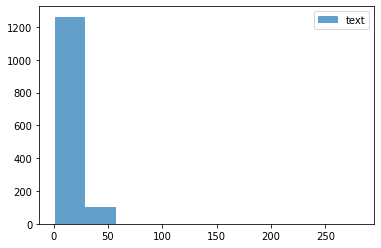

In [ ]:
import matplotlib.pyplot as plt

len_text = []
for data in ntext:
    len_text.append(len(data))
# 단어의 개수가 25개 미만 수가 대부분을 차지한다.
plt.hist(len_text, label='text', alpha=0.7)

plt.legend()
plt.show()

# BERT를 사용해보고 싶다.
- bert는 양방향
- gpt는 단방향
- elmo는 양방향

# BERT 준비 사항

In [21]:
# text
text = df["text"]
# BERT의 입력 형식에 맞게 변환
text = ["[CLS] " + str(sentence) + " [SEP]" for sentence in text]
text[:10]

['[CLS] 오예 오늘 휴강이다!!! [SEP]',
 '[CLS] 사랑한다. 이 세상 하나뿐인 내 아내와 아들, 딸 [SEP]',
 '[CLS] 오늘 감기에 걸렸다.. [SEP]',
 '[CLS] 놀이공원 놀러왔다 신난다! >_< [SEP]',
 '[CLS] 아 외롭다..ㅜ [SEP]',
 '[CLS] 와 진짜 억울하다 프로젝트 다 짰는데 날렸다.... 미친거 아냐?? 아... [SEP]',
 '[CLS] 아싸 시험 100점 ^^ [SEP]',
 '[CLS] 오늘 키우던 개가 죽었어... [SEP]',
 '[CLS] 헐 벌써 4월이야? 시간이 너무 빠르다! [SEP]',
 '[CLS] 대박 길 걷다가 만원 주웠다 ㅋㅋㅋ [SEP]']

Classification을 뜻하는 [CLS] 심볼
파인튜닝시 출력에서 이 위치의 값을 사용하여 분류
[SEP]은 Seperation을 가리키는데, 두 문장을 구분하는 역할을 함. 현재 문장은 하나이므로 [SEP]도 하나만 넣어준다.

In [22]:
# label이 문자이므로 숫자값으로 바꿔줘야함 - LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

sentiment = label_encoder.fit_transform(df["sentiment"])

# label_encoder.classes_
# label_encoder.inverse_transform(sentiment)

# sentiment = sentiment.reshape(-1,1)
sentiment

array([2, 3, 5, ..., 6, 4, 0])

# 원핫 인코딩

In [ ]:
# Loss값을 계산하기 쉽게 만들어주기위해 벡터화 -> 원-핫-인코더를 사용하여 값을 바꿈
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

ohe.fit(sentiment)

sentiment_onehot = ohe.transform(sentiment).toarray()
sentiment_onehot

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
sentiment_recovery = np.argmax(sentiment_onehot, axis=1).reshape(-1,1)
sentiment_recovery

array([[2],
       [3],
       [5],
       ...,
       [6],
       [4],
       [0]])

# 토크나이저

In [23]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in text]

print (text[0])
print (tokenized_texts[0])


[CLS] 오예 오늘 휴강이다!!! [SEP]
['[CLS]', '오', '##예', '오', '##늘', '휴', '##강', '##이다', '!', '!', '!', '[SEP]']


BERT는 형태소분석으로 토큰을 분리하지 않는다.
WordPiece라는 통계적인 방식을 사용, 한 단어내에서 자주 나오는 글자들을 붙여서 하나의 토큰으로 만든다. 이렇게 하면 언어에 상관없이 토큰을 생성할 수 있다는 장점이 있고, 신조어 같이 사전에 없는 단어를 처리하기도 좋다.<br><br>
위의 결과에서 ##기호는 앞 토큰과 이어진다는 표시. 토크나이저는 여러 언어의 데이터를 기반으로 만든 'bert-base-multilingul-cased'를 사용하여 한글도 처리가 가능하다.

In [24]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9580,  96279,   9580, 118762,  10013,  47181,  11925,
          106,    106,    106,    102,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

보통 딥러닝 모델에는 토큰 자체를 입력으로 넣을 수 없습니다. 임베딩 레이어에는 토큰을 숫자로 된 인덱스로 변환하여 사용합니다. BERT의 토크나이저는 {단어토큰:인덱스}로 구성된 단어사전을 가지고 있습니다. 이를 참조하여 토큰을 인덱스로 바꿔줍니다.
<br>
<br>
<br>

In [25]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [26]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    sentiment, 
                                                                                    random_state=2020, 
                                                                                    test_size=0.3)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2020, 
                                                       test_size=0.3)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

train_inputs.shape, train_labels.shape, train_masks.shape

tensor([   101,   9970,   8982,   9580, 118762,   9425,  25517,  11489,   9781,
         17196,  11287,   9640,  12945,  35506, 118666,  56645,   9609,  80046,
         12424,   9393, 119324, 119424,  41850,   9580, 118762,   9425,  25517,
          9521, 119163,  28911,   9309,  55358,   8982,   9032,  17196,  11102,
        119351,   9393, 119324,  41919,  27654,  41521,  12508,    102,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

(torch.Size([955, 128]), torch.Size([955]), torch.Size([955, 128]))

In [27]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# 전처리-테스트셋

In [30]:
# 테스트 셋
test_sentences = df["text"][100:400]
test_sentences

100    그나저나 자고 눈떳는데 트윗사진에 쥬니 븨앱도 했네,,, 보러가야겠다 투표만 마저 다하고
101    으으 유여님 팔찌 토백온인가욥???  넘 예뻐여,, ㅠㅠㅠㅠㅠ 물방울팔찌는 춘자님이...
102    홍대 크로와플. 주문하자마자 구워주셔서 따끈하고 바삭하다. 상당히 기름지기때문에 상...
103    쇼코 진짜 내 심장을 존내 폭행하고 간다 패션에서 쓰알을 얻으면 꼭 쇼코를 얻고싶어...
104              으으....하도 돌아다녔더니....그래도 푹 쉬었으니까 이제 괜찮아~!
                             ...                        
395               악!!!!!!!!! 여러분!!!! 10시 5분입니다!!!!!!!!!!
396                              인생 최고의 쇼!!!너무 재밌었어요 !!!
397                             너 때문에 너무 아파 너 때문에 너무 아파 
398                                       판넬이 너무 작은.... 
399    170521 인도네시아 팬들 응원 진짜 완전 너무 잘해주셔서 기분 조은 ㅎㅎㅎㅎㅎㅎ...
Name: text, Length: 300, dtype: object

In [31]:
# BERT의 입력 형식에 맞게 변환
test_sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in test_sentences]
test_sentences[:10]

['[CLS] 그나저나 자고 눈떳는데 트윗사진에 쥬니 븨앱도 했네,,, 보러가야겠다 투표만 마저 다하고 [SEP]',
 '[CLS] 으으 유여님 팔찌 토백온인가욥???  넘 예뻐여,, ㅠㅠㅠㅠㅠ 물방울팔찌는 춘자님이시구,,!! ㅠㅠㅜㅠㅠㅠㅠㅜ 넘 귀여워요 ㅠㅜㅠㅠㅜㅠㅜㅜㅜㅜ [SEP]',
 '[CLS] 홍대 크로와플. 주문하자마자 구워주셔서 따끈하고 바삭하다. 상당히 기름지기때문에 상큼한 과일 들어간 종류가 좋을 듯. 누텔라 추가도 가능! 기본 크로와플1800원, 바나나/딸기/키위/파인애플+휘핑크림은 2900원. 메론빵… [SEP]',
 '[CLS] 쇼코 진짜 내 심장을 존내 폭행하고 간다 패션에서 쓰알을 얻으면 꼭 쇼코를 얻고싶어 😊😊😊 [SEP]',
 '[CLS] 으으....하도 돌아다녔더니....그래도 푹 쉬었으니까 이제 괜찮아~! [SEP]',
 '[CLS] 김남준때문에 살수가없어ㅠㅠㅠ  [SEP]',
 '[CLS] 됴야 보면 행복해ㅠㅠㅠㅠ  [SEP]',
 '[CLS] 방금 방송에 나왔는데 오솔길은 오소리길에서 나왔다고 한다. 오소리가 다리가 짧아 배가 끌려서 사람 혼자 걷기 좋은 길이 만들어진다고 한다. 😂 [SEP]',
 '[CLS] 이렇게나 멋진 은발에 간지 터지는 패션감각의 어른이 신임 외교부장관 내정자라는 게 실화냐 진짜. 외모패권주의라는 이번 정부의 정점 아니냐 정말.  [SEP]',
 '[CLS] 좋아요! 그럼 벌 받지않게 많이많이 가져올게요! [SEP]']

In [32]:
# label이 문자이므로 숫자값으로 바꿔줘야함 - LabelEncoder
from sklearn.preprocessing import LabelEncoder
test_label_encoder = LabelEncoder()

test_sentiment = test_label_encoder.fit_transform(df["sentiment"][100:400])

# label_encoder.classes_
# label_encoder.inverse_transform(sentiment)

# test_sentiment = test_sentiment.reshape(-1,1)
test_sentiment

array([4, 2, 4, 2, 5, 5, 2, 4, 0, 2, 4, 4, 4, 5, 2, 2, 4, 2, 5, 6, 2, 2,
       6, 2, 0, 2, 0, 2, 2, 2, 2, 6, 0, 0, 6, 4, 2, 0, 0, 2, 3, 2, 5, 2,
       0, 2, 2, 2, 2, 6, 5, 2, 2, 0, 5, 4, 5, 0, 5, 6, 2, 2, 0, 0, 0, 0,
       2, 2, 0, 2, 4, 2, 2, 2, 0, 5, 3, 2, 3, 5, 2, 5, 5, 0, 5, 2, 2, 5,
       5, 0, 5, 5, 4, 2, 4, 4, 2, 3, 6, 4, 5, 5, 2, 2, 2, 5, 3, 2, 4, 4,
       5, 4, 2, 2, 6, 5, 6, 4, 5, 2, 4, 2, 0, 5, 2, 0, 1, 0, 3, 2, 5, 2,
       6, 2, 2, 5, 2, 5, 4, 2, 2, 5, 3, 5, 4, 4, 2, 2, 5, 2, 2, 5, 2, 3,
       5, 5, 5, 6, 6, 2, 2, 2, 2, 3, 2, 5, 5, 2, 6, 2, 3, 0, 5, 3, 5, 2,
       2, 2, 2, 4, 2, 2, 5, 5, 6, 4, 3, 0, 5, 5, 3, 6, 2, 2, 3, 2, 2, 5,
       5, 2, 2, 6, 3, 5, 3, 2, 2, 2, 6, 2, 2, 2, 6, 3, 2, 5, 2, 6, 5, 5,
       2, 3, 2, 6, 3, 5, 2, 2, 5, 2, 2, 0, 2, 2, 4, 4, 6, 4, 2, 5, 3, 2,
       6, 2, 5, 2, 0, 2, 0, 5, 5, 2, 5, 5, 2, 2, 6, 0, 2, 2, 2, 2, 0, 0,
       2, 4, 4, 2, 2, 2, 2, 2, 5, 2, 2, 3, 0, 5, 0, 2, 2, 5, 2, 2, 1, 0,
       2, 6, 4, 2, 4, 2, 2, 0, 2, 2, 2, 5, 5, 2])

#원핫인코딩

In [ ]:
# Loss값을 계산하기 쉽게 만들어주기위해 벡터화 -> 원-핫-인코더를 사용하여 값을 바꿈

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

ohe.fit(test_sentiment)

test_sentiment_onehot = ohe.transform(test_sentiment).toarray()

In [ ]:
test_sentiment_onehot

# 토크나이저

In [33]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]

print (test_sentences[0])
print (tokenized_texts[0])
# UNK는 뭐지? Unknown

[CLS] 그나저나 자고 눈떳는데 트윗사진에 쥬니 븨앱도 했네,,, 보러가야겠다 투표만 마저 다하고 [SEP]
['[CLS]', '그', '##나', '##저', '##나', '자', '##고', '[UNK]', '트', '##윗', '##사', '##진', '##에', '쥬', '##니', '[UNK]', '했', '##네', ',', ',', ',', '보', '##러', '##가', '##야', '##겠', '##다', '투', '##표', '##만', '마', '##저', '다', '##하고', '[SEP]']


In [34]:
# 입력 토큰의 최대 시퀀스 길이 128
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   8924,  16439,  48387,  16439,   9651,  11664,    100,
         9890, 119180,  12945,  18623,  10530,   9698,  25503,    100,
         9965,  77884,    117,    117,    117,   9356,  30873,  11287,
        21711, 118632,  11903,   9881,  37824,  19105,   9246,  48387,
         9056,  12453,    102,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [35]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [36]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(test_sentiment)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([   101,   8924,  16439,  48387,  16439,   9651,  11664,    100,   9890,
        119180,  12945,  18623,  10530,   9698,  25503,    100,   9965,  77884,
           117,    117,    117,   9356,  30873,  11287,  21711, 118632,  11903,
          9881,  37824,  19105,   9246,  48387,   9056,  12453,    102,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [37]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# 모델 생성

In [38]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [39]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


In [ ]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=7)
model.cuda()

In [41]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [42]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [43]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [44]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        print(b_labels)

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
tensor([2, 5, 2, 5, 2, 2, 2, 5, 5, 0, 2, 2, 2, 6, 5, 2, 5, 2, 2, 2, 4, 4, 2, 2,
        2, 4, 2, 2, 5, 2, 6, 5], device='cuda:0')
tensor([5, 2, 3, 4, 2, 2, 4, 0, 4, 0, 2, 2, 2, 6, 5, 2, 5, 6, 5, 2, 5, 5, 3, 4,
        2, 2, 0, 0, 0, 0, 2, 5], device='cuda:0')
tensor([5, 1, 5, 2, 2, 5, 6, 3, 2, 2, 2, 2, 2, 4, 2, 2, 5, 5, 2, 2, 2, 5, 2, 5,
        3, 2, 2, 6, 2, 5, 2, 5], device='cuda:0')
tensor([0, 0, 4, 4, 2, 5, 2, 2, 6, 1, 5, 5, 5, 2, 2, 2, 2, 5, 2, 5, 5, 2, 2, 2,
        5, 2, 6, 5, 2, 0, 3, 5], device='cuda:0')
tensor([4, 2, 2, 4, 6, 2, 2, 4, 4, 6, 2, 5, 4, 5, 5, 2, 5, 5, 0, 2, 0, 2, 6, 6,
        0, 4, 6, 0, 2, 4, 2, 2], device='cuda:0')
tensor([2, 2, 4, 2, 1, 0, 2, 4, 2, 4, 2, 5, 2, 2, 0, 6, 2, 2, 5, 5, 5, 2, 2, 2,
        4, 5, 3, 0, 2, 2, 2, 4], device='cuda:0')
tensor([2, 2, 5, 5, 5, 5, 2, 0, 5, 5, 2, 2, 4, 0, 5, 5, 0, 2, 2, 4, 5, 0, 5, 4,
        0, 6, 2, 0, 5, 0, 2, 2], device='cuda:0')
tensor([0, 2, 5, 0, 6, 2, 5, 2, 2, 5, 6, 0, 0, 

에폭마다 훈련셋과 검증셋을 반복하여 학습을 수행합니다.

# 테스트셋 평가

In [45]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.54
Test took: 0:00:02


In [46]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [47]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [48]:
sentiment_dic = {
    0 : 'anger',
    1 : 'fear',
    2 : 'joy',
    3 : 'love',
    4 : 'neutral',
    5 : 'sadness',
    6 : 'surprise',
}

# ['anger', 'fear', 'joy', 'love', 'neutral', 'sadness', 'surprise']

In [49]:
logits = test_sentences(['연기는 별로지만 재미 하나는 끝내줌!'])

print(logits)
print(np.argmax(logits))
label_encoder.classes_
# label_encoder.inverse_transform(sentiment)

[[ 0.09699566 -1.1918273   2.0607374  -0.39998493  0.20660418  0.04119709
  -0.542602  ]]
2


array(['anger', 'fear', 'joy', 'love', 'neutral', 'sadness', 'surprise'],
      dtype=object)

In [50]:
logits = test_sentences(['오랜만에 할일도 없고 우울하다.'])

print(logits)
print(np.argmax(logits))

label_encoder.classes_
# label_encoder.inverse_transform(sentiment)

[[ 1.0333513  -0.90803534 -0.2819434  -0.63499206 -0.20072287  1.5781634
  -0.25004724]]
5


array(['anger', 'fear', 'joy', 'love', 'neutral', 'sadness', 'surprise'],
      dtype=object)

In [44]:
logits = test_sentences(['너무 슬프고 아프다'])

print(logits)
print(np.argmax(logits))

label_encoder.classes_
# label_encoder.inverse_transform(sentiment)

[[ 0.04015924 -1.3681433   1.6003764  -0.76655084 -0.15874612  0.93945116
  -0.32084122]]
2


array(['anger', 'fear', 'joy', 'love', 'neutral', 'sadness', 'surprise'],
      dtype=object)

In [51]:
logits = test_sentences(['아무것다 하기 싫다. 우울하다 ㅠㅠ'])

print(logits)
print(np.argmax(logits))

label_encoder.classes_
# label_encoder.inverse_transform(sentiment)

[[ 0.9894172  -0.9234535  -0.00456132 -0.7567447  -0.30358368  1.6172425
  -0.14679784]]
5


array(['anger', 'fear', 'joy', 'love', 'neutral', 'sadness', 'surprise'],
      dtype=object)

In [52]:
# print(sentiment_dic[np.argmax(logits)])
print(crawling_data[:10])
# crawling_data["sentiment"] = crawling_data["text"].apply(test_sentences)
crawling_data["sentiment"] = crawling_data["text"].apply(lambda x: test_sentences([x]))
crawling_data["sentiment"] = crawling_data["sentiment"].apply(lambda x: np.argmax(x))


                                                text
0     (저어엄프으으!!!!)(낚아채기!)(잘 굴러서 머스타드를 구해냈다!!) 짜자아아안!
1  하트만 빨간색으로 포인트 준 것두 진짜ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ넘 귀여워요ㅠㅠㅠㅠㅠㅠ 그리...
2                                        진짜 이상한 놈이야 
3                                     나 아직 고스트으으으ㅠ.ㅠ
4  예전에도 한번 영업한적 있지만 이 가방은 진짜 넘나 짱입니다. 특히 해외 여행/출장...
5  선생님들 정말 저 열심히 찍어보겠습니다........ 😭💦💦💦💦..... 원가 양도...
6  길을 비켜라 애기 요정 나가신다💓 (심장을 부여잡는다) 진짜 거짓말 안하고 뚜뚜요정...
7               170531 유해브어드림 흑발백현 섹시터짐미다...너무 좋네요😱 
8                               포스트잇 제발 다시 붙여놔줘요....
9                                  이게무슨일이야 이렇게 좋은 날에


In [53]:
print(crawling_data.sentiment.value_counts())
print(sentiment_dic)

2    470
5    149
0    148
4     24
1     19
Name: sentiment, dtype: int64
{0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


In [83]:
crawling_data

,text,sentiment
0,(저어엄프으으!!!!)(낚아채기!)(잘 굴러서 머스타드를 구해냈다!!) 짜자아아안!,2
1,하트만 빨간색으로 포인트 준 것두 진짜ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ넘 귀여워요ㅠㅠㅠㅠㅠㅠ 그리...,2
2,진짜 이상한 놈이야,2
3,나 아직 고스트으으으ㅠ.ㅠ,2
4,예전에도 한번 영업한적 있지만 이 가방은 진짜 넘나 짱입니다. 특히 해외 여행/출장...,2
...,...,...
805,나는 대회랑 조별 수행평가 3개 혼자서 동시에 준비하고 숙제 다 하고나서도 11시 ...,2
806,총이라는거 자체가 표적을 쏘는 물건이기 때문에 장난감이라도 표적을 두고 쏘려고들 함...,2
807,헉 정말요? .....뭔가 그사람들은 이번엔 뭘낼까 고민하는것도 일이겠어요... 아...,5
808,"황효명, 유호연, 동려아 주연의 드라마 &lt;랑야방지풍기장림&gt;이 11월 20...",2


In [62]:
crawling_data.to_csv("crawling_data.tsv", header=True, sep="\t")

In [63]:
z = pd.read_csv("/content/crawling_data.tsv", sep="\t")
z = z.drop("Unnamed: 0", axis=1)
z

,text,sentiment
0,(저어엄프으으!!!!)(낚아채기!)(잘 굴러서 머스타드를 구해냈다!!) 짜자아아안!,2
1,하트만 빨간색으로 포인트 준 것두 진짜ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ넘 귀여워요ㅠㅠㅠㅠㅠㅠ 그리...,2
2,진짜 이상한 놈이야,5
3,나 아직 고스트으으으ㅠ.ㅠ,2
4,예전에도 한번 영업한적 있지만 이 가방은 진짜 넘나 짱입니다. 특히 해외 여행/출장...,2
...,...,...
805,나는 대회랑 조별 수행평가 3개 혼자서 동시에 준비하고 숙제 다 하고나서도 11시 ...,4
806,총이라는거 자체가 표적을 쏘는 물건이기 때문에 장난감이라도 표적을 두고 쏘려고들 함...,0
807,헉 정말요? .....뭔가 그사람들은 이번엔 뭘낼까 고민하는것도 일이겠어요... 아...,5
808,"황효명, 유호연, 동려아 주연의 드라마 &lt;랑야방지풍기장림&gt;이 11월 20...",4


In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 695840K
-rw-r--r-- 1 root root      1K Sep 14 02:20 config.json
-rw-r--r-- 1 root root 694847K Sep 14 02:20 pytorch_model.bin
-rw-r--r-- 1 root root      1K Sep 14 02:20 special_tokens_map.json
-rw-r--r-- 1 root root      1K Sep 14 02:20 tokenizer_config.json
-rw-r--r-- 1 root root    973K Sep 14 02:20 vocab.txt


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 679M Sep 14 02:20 ./model_save/pytorch_model.bin


In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/BERT Fine-Tuning/"

In [ ]:
import torch
torch.save(model, './model')

saved_model = torch.load('./model')

In [ ]:
print(torch.__version__)

1.6.0+cu101


In [ ]:
df[df["sentiment"] == "fear"]

,text,sentiment
11,어젯밤에 누가 계속 따라오는 것 같았다. 너무 무서웠다.. 그래서 빨리 뛰었는데 그...,fear
226,아.. 연습 하나도 안했는데 ㅠㅠ 선생님 보기가 두렵다,fear
384,집오는 길이 너무 어둡고 음산했다 데려다줄 누군가가 있었으면 좋겠다.,fear
523,겟아웃 너무 무서웠어...... 아직도 여운이 남네,fear
537,역시...못가게따...흑흑 무셔,fear
730,미친 뮤비 멤버 각각 개인샷에서는 무표정이거나 정색하는데 단체샷이나 같이 있는 장면...,fear
736,...무섭네요. 숨겨진 배후가..?,fear
739,'이상적 여성의 신체' 내지 이와 은근슬쩍 혼용돼서 쓰이는 '평균적 여성의 신체'(...,fear
741,헉 아안대요 무서워 그럼 초르니는 다시 뒤돌아보기 전에 머리보다 몸통이 큰 곰돌이 ...,fear
760,기숙사 방에 들어온 벌레가 분명 문을 닫았는데 사라져서 무섭다,fear
